In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv(f"../data/input_data/MAIN_DATASET.csv", index_col=[0])
df['year'] = pd.DatetimeIndex(df['date_time']).year
df['month'] = pd.DatetimeIndex(df['date_time']).month
selceted_df = df[df['year'] == 2021]
selceted_df = selceted_df[selceted_df['month'] >= 6]
selceted_df.head()


,index,NO2_price,NO2_load_actual,NO2_load_forecasted,NO2_load_delta,NO2_generation_actual,NO2_generation_forecast,NO2_generation_delta,NO5_price,NO5_load_actual,...,NO5_load_delta,NO5_generation_actual,NO5_generation_forecast,NO5_generation_delta,NO2_Fyllingsgrad_NVE,NO5_Fyllingsgrad_NVE,dato_id,date_time,year,month
47411,2021-06-01 00:00:00+02:00,56.69,3496,2691,-805,11870,6179,-5691,41.82,1635,...,401,5004,2057,-2947,0.579739,0.302678,2021-06-01 00:00:00+02:00,2021-06-01-00,2021,6
47412,2021-06-01 01:00:00+02:00,56.41,3371,2761,-610,11892,6187,-5705,40.45,1620,...,350,4726,1939,-2787,0.579974,0.303149,2021-06-01 01:00:00+02:00,2021-06-01-01,2021,6
47413,2021-06-01 02:00:00+02:00,54.69,3304,2667,-637,11912,5999,-5913,38.88,1580,...,344,4622,1912,-2710,0.580209,0.303619,2021-06-01 02:00:00+02:00,2021-06-01-02,2021,6
47414,2021-06-01 03:00:00+02:00,54.43,3300,2568,-732,11692,5973,-5719,37.86,1577,...,278,4570,1897,-2673,0.580445,0.304090,2021-06-01 03:00:00+02:00,2021-06-01-03,2021,6
47415,2021-06-01 04:00:00+02:00,55.12,3219,2627,-592,11862,6037,-5825,37.80,1597,...,256,4526,1893,-2633,0.580680,0.304560,2021-06-01 04:00:00+02:00,2021-06-01-04,2021,6


In [3]:
day_ahead_prices = selceted_df[["dato_id","NO2_price", "NO5_price"]]
day_ahead_prices.head()

,dato_id,NO2_price,NO5_price
47411,2021-06-01 00:00:00+02:00,56.69,41.82
47412,2021-06-01 01:00:00+02:00,56.41,40.45
47413,2021-06-01 02:00:00+02:00,54.69,38.88
47414,2021-06-01 03:00:00+02:00,54.43,37.86
47415,2021-06-01 04:00:00+02:00,55.12,37.80


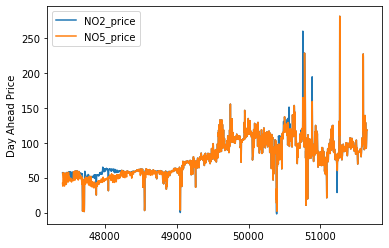

In [4]:
ax = day_ahead_prices.plot()
ax.set_ylabel("Day Ahead Price")
plt.show()

### Test if data is stationary: 

p_value=0.00603917699671059, differencing data


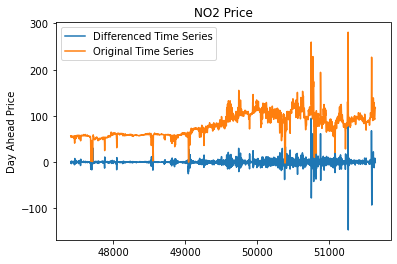

p_value=0.01997146645368157, differencing data


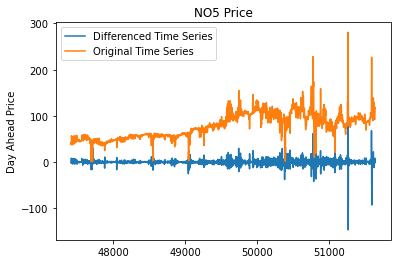

In [5]:
def hypothesis_test(df:pd.DataFrame):
    result = adfuller(df)
    #print(result)
    p_value = result[1]
    if p_value > 0.005: 
        print(f"{p_value=}, differencing data")
        df = df.diff()
        return df
    else:
        print(f"{p_value=}>0.05, no need to difference data")
        return df

differenced_NO2 = hypothesis_test(day_ahead_prices["NO2_price"])

ax1 = differenced_NO2.plot(label = "Differenced Time Series")
day_ahead_prices["NO2_price"].plot(ax=ax1, label = "Original Time Series")
ax1.set_ylabel("Day Ahead Price")
plt.title("NO2 Price")
plt.legend()
plt.show()

differenced_NO5 = hypothesis_test(day_ahead_prices["NO5_price"])

ax2 = differenced_NO5.plot(label = "Differenced Time Series")
day_ahead_prices["NO5_price"].plot(ax=ax2, label = "Original Time Series")
ax2.set_ylabel("Day Ahead Price")
plt.title("NO5 Price")

plt.legend()
plt.show()

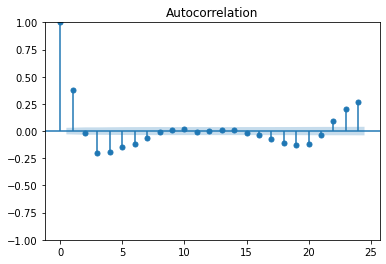

In [6]:
plot_acf(differenced_NO5.dropna(), lags=24)
plt.show()

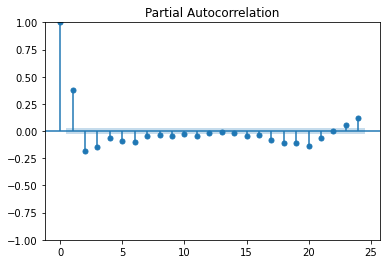

In [7]:
plot_pacf(differenced_NO5.dropna(),method='ywm', lags = 24)
plt.show()



Test R2: 0.3826348140882667


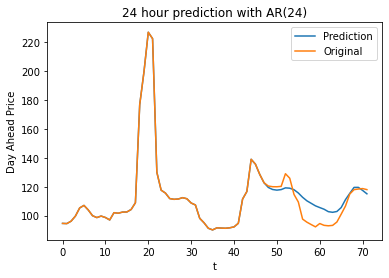

In [9]:
from sklearn.metrics import r2_score


n_steps = 24

train = list(differenced_NO5.dropna())[:-n_steps]
test = list(day_ahead_prices["NO5_price"])[-n_steps:]

order = 24
coefficients, sigma = yule_walker(train, order = order)

# Make a list of differenced values
val_list = list(train)
# Reverse the list so that the order corresponds with the order of the coefficients
val_list.reverse()
# Define the number of years to predict

# For each year to predict
for i in range(n_steps):
    
    # Compute the new value as the sum of lagged values multiplied by their corresponding coefficient
    new_val = 0
    for j in range(len(coefficients)):
        
        new_val += coefficients[j] * val_list[j]
    
    # Insert the new value at the beginning of the list
    val_list.insert(0, new_val)

# Redo the reverso to have the order of time
val_list.reverse()

# Add the original first value back into the list and do a cumulative sum to undo the differencing 
val_list = [day_ahead_prices["NO5_price"].values[0]] + val_list
new_val_list = pd.Series(val_list).cumsum()

# Plot the newly obtained list
validation = pd.DataFrame({
    'Prediction': new_val_list,
    'Original': day_ahead_prices["NO5_price"].reset_index(drop=True),
    'date': day_ahead_prices["dato_id"].reset_index(drop=True)
     })

print('Test R2:', r2_score(validation.iloc[-10:, 0], validation.iloc[-10:, 1]))

# Plot the newly obtained list
plot_window = n_steps+48

plt.plot(np.arange(plot_window),validation["Prediction"].tail(plot_window))
plt.plot(np.arange(plot_window),validation["Original"].tail(plot_window))
plt.legend(validation.columns)
plt.title(f"{n_steps} hour prediction with AR({order})")
plt.ylabel('Day Ahead Price')
plt.xlabel('t')
plt.show()